<a href="https://colab.research.google.com/github/Shivdutta/AdvanceCNN/blob/master/Pred_CiFAR10_Fashion_classification_resnet50_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
#from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
#from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths

from datetime import datetime

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!unzip -q "/content/gdrive/My Drive/CNN_Images/VGG_class_data.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
!ls /content/data/train

backpack  footwear  glasses  watch


In [21]:
# useful for getting number of classes
folders = glob('data/train/*')
print(len(folders))

4


In [0]:
#Give dataset path
trainpath = "/content/data/train/"
testpath = "/content/data/test/"
classes = 4
Image_Size =128
batch_size=20

INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 20
MODEL_PATH = "fashion_resnet.model"

In [26]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False



[INFO] preparing model...


In [36]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Data Augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 475 images belonging to 4 classes.
Found 264 images belonging to 4 classes.


In [39]:

# compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])
# train the model
print("[INFO] training model...")



#lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                               cooldown=0,
#                               patience=5,
#                               min_lr=0.5e-6)

#num_epochs = 1000
#num_batch_size = 32

checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=NUM_EPOCHS,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

[INFO] training model...
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5/5 [==============================] - ETA: 0s - loss: 1.9728 - accuracy: 0.5000
Epoch 00001: val_loss improved from inf to 0.74582, saving model to mymodel.h5
5/5 [==============================] - 26s 5s/step - loss: 1.9728 - accuracy: 0.5000 - val_loss: 0.7458 - val_accuracy: 0.7290
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.8125
Epoch 00002: val_loss improved from 0.74582 to 0.55837, saving model to mymodel.h5
5/5 [==============================] - 26s 5s/step - loss: 0.5977 - accuracy: 0.8125 - val_loss: 0.5584 - val_accuracy: 0.8470
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.9032
Epoch 00003: val_loss improved from 0.55837 to 0.25289, saving model to mymodel.h5
5/5 [==============================] - 26s 5s/step - loss: 0.3484 - accuracy: 0.9032 - val_loss: 0.2529 - val_accuracy: 0.9044
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9500
Epoch 00004: val_

4


In [41]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_set.reset()
predIdxs = model.predict_generator(test_set,	steps=(len(list(paths.list_files(testpath))) // BS) + 1)
predIdxs

[INFO] evaluating network...
Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[4.8585460e-09, 2.8159695e-08, 1.0000000e+00, 1.5150701e-09],
       [9.9957162e-01, 3.3698190e-05, 2.9794802e-04, 9.6707226e-05],
       [3.4822937e-13, 7.0339279e-10, 1.1588251e-13, 1.0000000e+00],
       ...,
       [1.9026457e-08, 3.3130096e-11, 1.0000000e+00, 1.5989888e-12],
       [3.8274573e-16, 1.0321651e-14, 1.0000000e+00, 4.1537706e-12],
       [3.3779954e-09, 1.2503614e-11, 1.5031120e-11, 1.0000000e+00]],
      dtype=float32)

In [42]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
predIdxs

array([2, 0, 3, 3, 0, 0, 0, 3, 0, 1, 1, 3, 3, 3, 2, 1, 1, 3, 2, 3, 3, 1,
       0, 3, 0, 1, 1, 3, 2, 3, 3, 2, 0, 3, 2, 2, 2, 1, 1, 0, 3, 0, 0, 0,
       2, 0, 3, 2, 1, 0, 2, 1, 1, 1, 3, 1, 2, 1, 3, 0, 3, 0, 2, 2, 1, 2,
       1, 1, 2, 1, 2, 2, 2, 0, 0, 3, 0, 0, 1, 2, 2, 1, 3, 0, 0, 2, 3, 0,
       1, 2, 0, 3, 3, 0, 2, 0, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 2, 0, 0, 3,
       0, 1, 1, 3, 2, 0, 2, 2, 1, 3, 3, 2, 3, 0, 0, 0, 1, 0, 3, 2, 0, 3,
       2, 2, 2, 2, 3, 2, 0, 3, 1, 2, 3, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 3,
       3, 0, 1, 1, 3, 0, 0, 2, 2, 1, 2, 0, 2, 2, 3, 1, 2, 2, 0, 1, 3, 0,
       2, 2, 1, 3, 0, 3, 1, 1, 3, 0, 1, 0, 2, 1, 1, 3, 0, 3, 0, 0, 1, 0,
       3, 2, 3, 3, 2, 0, 3, 0, 1, 1, 1, 3, 0, 1, 1, 2, 3, 3, 1, 3, 1, 0,
       2, 3, 1, 2, 3, 0, 3, 1, 2, 1, 2, 3, 3, 1, 0, 2, 1, 2, 3, 1, 0, 3,
       0, 1, 3, 3, 3, 1, 3, 1, 2, 2, 3, 1, 0, 1, 1, 0, 3, 0, 2, 2, 2, 3])

In [45]:
print(classification_report(test_set.classes, predIdxs,
	target_names=test_set.class_indices.keys()))
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

              precision    recall  f1-score   support

    backpack       0.24      0.24      0.24        66
    footwear       0.25      0.26      0.26        66
     glasses       0.30      0.29      0.29        66
       watch       0.32      0.33      0.33        66

    accuracy                           0.28       264
   macro avg       0.28      0.28      0.28       264
weighted avg       0.28      0.28      0.28       264

[INFO] saving model...


In [0]:
model_loaded = tf.keras.models.load_model(MODEL_PATH)

In [48]:
test_set.class_indices.keys()

dict_keys(['backpack', 'footwear', 'glasses', 'watch'])

In [49]:
!ls /content/data/test/watch

00000000.jpg  00000016.jpg  00000032.jpeg  00000049.jpg   00000069.jpg
00000001.jpg  00000018.jpg  00000033.jpg   00000050.jpg   00000070.jpg
00000002.jpg  00000019.jpg  00000034.jpg   00000051.jpg   00000071.jpg
00000003.jpg  00000020.jpg  00000035.jpg   00000053.jpg   00000072.jpg
00000004.jpg  00000022.jpg  00000037.jpg   00000054.jpg   00000073.jpg
00000005.jpg  00000023.jpg  00000038.jpg   00000055.jpeg  00000074.jpg
00000006.jpg  00000024.jpg  00000039.jpeg  00000057.jpg   00000075.jpg
00000007.jpg  00000025.jpg  00000041.jpg   00000059.jpg   00000076.jpg
00000008.jpg  00000026.jpg  00000042.jpg   00000060.jpg   00000079.jpg
00000010.jpg  00000027.jpg  00000043.jpg   00000061.jpg   00000080.jpg
00000011.jpg  00000028.jpg  00000044.jpg   00000063.jpg
00000012.jpg  00000029.jpg  00000045.jpg   00000064.jpeg
00000014.jpg  00000030.jpg  00000046.jpg   00000066.jpg
00000015.jpg  00000031.jpg  00000048.jpeg  00000067.jpg


Input Dimensions - Image :  (128, 128, 3)


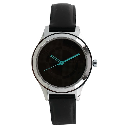

None
dict_keys(['backpack', 'footwear', 'glasses', 'watch'])
[[0.00972684 0.00096219 0.921381   0.06793003]]


In [55]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img_o= "/content/data/test/watch/00000049.jpg"
input_img = io.imread(input_img_o)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
print(cv2_imshow(input_img))

#Reference https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image
#Since you trained your model on mini-batches, your input is a tensor of shape [batch_size, image_width, image_height, number_of_channels].
#When predicting, you have to respect this shape even if you have only one image. Your input should be of shape: [1, image_width, image_height, number_of_channels].

from PIL import Image
#import numpy as np
from skimage import transform
def load(filename):
   input_img = io.imread(filename)
   np_image = cv2.resize(input_img, dsize=(224, 224))
   #np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(input_img_o)
print((test_set.class_indices.keys()))
print(model.predict(image))

In [56]:
!ls /content/data/test/glasses

00000465.jpg  00000483.jpg  00000500.jpg   00000515.jpg   00000532.jpg
00000466.jpg  00000484.jpg  00000501.jpg   00000516.jpg   00000533.jpg
00000468.jpg  00000486.jpg  00000502.jpg   00000517.jpg   00000534.jpg
00000470.jpg  00000487.jpg  00000503.jpg   00000518.jpg   00000535.jpg
00000471.jpg  00000488.jpg  00000504.jpg   00000519.jpg   00000536.png
00000472.jpg  00000489.jpg  00000505.jpg   00000520.jpg   00000539.jpg
00000473.jpg  00000490.jpg  00000506.jpg   00000522.jpg   00000540.jpeg
00000475.jpg  00000491.jpg  00000507.jpg   00000523.jpeg  00000541.jpg
00000476.jpg  00000492.jpg  00000508.jpeg  00000524.jpg   00000542.jpg
00000477.jpg  00000495.jpg  00000509.jpg   00000525.jpg   00000543.jpg
00000479.jpg  00000496.jpg  00000511.jpg   00000526.jpg
00000480.jpg  00000497.jpg  00000512.jpg   00000528.jpg
00000481.jpg  00000498.jpg  00000513.jpg   00000529.jpg
00000482.jpg  00000499.jpg  00000514.jpg   00000530.jpg


Input Dimensions - Image :  (128, 128, 3)


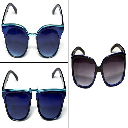

None
dict_keys(['backpack', 'footwear', 'glasses', 'watch'])
[[0.01710733 0.00101216 0.8584082  0.1234723 ]]


In [57]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img_o= "/content/data/test/glasses/00000530.jpg"
input_img = io.imread(input_img_o)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
print(cv2_imshow(input_img))

#Reference https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image
#Since you trained your model on mini-batches, your input is a tensor of shape [batch_size, image_width, image_height, number_of_channels].
#When predicting, you have to respect this shape even if you have only one image. Your input should be of shape: [1, image_width, image_height, number_of_channels].

from PIL import Image
#import numpy as np
from skimage import transform
def load(filename):
   input_img = io.imread(filename)
   np_image = cv2.resize(input_img, dsize=(224, 224))
   #np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(input_img_o)
print((test_set.class_indices.keys()))
print(model.predict(image))

In [58]:
!ls /content/data/test/backpack

00000010.png  00000269.png  00000335.jpg  00000350.jpg	00000368.jpg
00000018.png  00000270.png  00000336.jpg  00000351.jpg	00000370.png
00000027.png  00000275.png  00000337.jpg  00000352.jpg	00000371.jpg
00000053.png  00000324.jpg  00000338.jpg  00000353.jpg	00000372.jpg
00000069.png  00000325.jpg  00000340.jpg  00000354.jpg	00000374.jpg
00000131.png  00000326.jpg  00000341.png  00000355.jpg	00000375.jpg
00000137.png  00000327.jpg  00000342.jpg  00000356.jpg	00000376.jpg
00000198.png  00000328.jpg  00000343.jpg  00000357.jpg	00000377.jpg
00000199.png  00000329.png  00000344.jpg  00000359.jpg	00000378.jpg
00000208.png  00000330.png  00000345.jpg  00000360.jpg	00000379.jpg
00000214.png  00000331.jpg  00000346.jpg  00000361.jpg
00000217.png  00000332.jpg  00000347.jpg  00000362.jpg
00000245.png  00000333.jpg  00000348.jpg  00000363.jpg
00000267.png  00000334.jpg  00000349.jpg  00000366.jpg


Input Dimensions - Image :  (128, 128, 3)


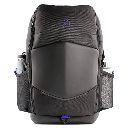

None
dict_keys(['backpack', 'footwear', 'glasses', 'watch'])
[[0.01170626 0.00134483 0.8793317  0.10761721]]


In [59]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img_o= "/content/data/test/backpack/00000366.jpg"
input_img = io.imread(input_img_o)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
print(cv2_imshow(input_img))

#Reference https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image
#Since you trained your model on mini-batches, your input is a tensor of shape [batch_size, image_width, image_height, number_of_channels].
#When predicting, you have to respect this shape even if you have only one image. Your input should be of shape: [1, image_width, image_height, number_of_channels].

from PIL import Image
#import numpy as np
from skimage import transform
def load(filename):
   input_img = io.imread(filename)
   np_image = cv2.resize(input_img, dsize=(224, 224))
   #np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(input_img_o)
print((test_set.class_indices.keys()))
print(model.predict(image))

In [60]:
!ls /content/data/test/footwear/

00000407.jpg  00000422.jpg  00000437.jpg   00000451.jpg  00000465.jpg
00000408.jpg  00000423.jpg  00000438.jpeg  00000452.jpg  00000466.jpeg
00000409.jpg  00000424.jpg  00000439.jpg   00000453.jpg  00000467.jpg
00000410.jpg  00000426.jpg  00000440.jpg   00000454.jpg  00000468.jpg
00000411.jpg  00000427.jpg  00000441.jpeg  00000455.JPG  00000469.jpeg
00000412.jpg  00000428.jpg  00000442.jpg   00000456.jpg  00000470.jpg
00000413.jpg  00000429.jpg  00000443.jpg   00000457.jpg  00000471.jpg
00000414.jpg  00000430.jpg  00000444.jpg   00000458.jpg  00000472.jpg
00000415.jpg  00000431.png  00000445.jpg   00000459.jpg  00000473.jpg
00000416.jpg  00000432.jpg  00000446.jpg   00000460.jpg  00000474.jpg
00000417.jpg  00000433.jpg  00000447.jpg   00000461.jpg
00000418.jpg  00000434.jpg  00000448.jpg   00000462.jpg
00000419.png  00000435.jpg  00000449.jpg   00000463.jpg
00000420.jpg  00000436.jpg  00000450.jpg   00000464.jpg


Input Dimensions - Image :  (128, 128, 3)


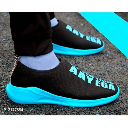

None
dict_keys(['backpack', 'footwear', 'glasses', 'watch'])
[[0.00796772 0.00101159 0.9341711  0.05684955]]


In [62]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img_o= "/content/data/test/footwear/00000466.jpeg"
input_img = io.imread(input_img_o)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
print(cv2_imshow(input_img))

#Reference https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image
#Since you trained your model on mini-batches, your input is a tensor of shape [batch_size, image_width, image_height, number_of_channels].
#When predicting, you have to respect this shape even if you have only one image. Your input should be of shape: [1, image_width, image_height, number_of_channels].

from PIL import Image
#import numpy as np
from skimage import transform
def load(filename):
   input_img = io.imread(filename)
   np_image = cv2.resize(input_img, dsize=(224, 224))
   #np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(input_img_o)
print((test_set.class_indices.keys()))
print(model.predict(image))